In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap

import re
import json

e:\anaconda3\envs\BERT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = BertTokenizer.from_pretrained('../../model/bert-base-chinese')
model = BertModel.from_pretrained('../../model/bert-base-chinese')


def get_embedding_mean(x):
    inputs = tokenizer(x, return_tensors="pt", truncation=True)
    outputs = model(**inputs, output_hidden_states=True)
    last_hidden_states = outputs[0]
    embeddings = last_hidden_states[0].detach().numpy()
    embeddings = np.mean(embeddings[:], axis=0)
    return embeddings

# Import data

In [3]:
combine_feature = pd.read_excel('combine_feature_all_fianl_251018.xlsx',index_col=0)
combine_feature = combine_feature.loc[combine_feature['moral_related'] == 1]

# Similarity distribution

In [4]:
vectors = np.array([get_embedding_mean(word) for word in combine_feature['feature']])

matrix = vectors 
vector_df = pd.DataFrame(vectors, index=combine_feature['feature'])
print(vector_df.shape)

similarity_matrix = cosine_similarity(vectors)
similarity_df = pd.DataFrame(similarity_matrix, index=vector_df.index, columns=vector_df.index)
similarity_df

(2061, 768)


feature,自主侵犯,背叛,违抗权威,欲望,厌恶,公平违背,危害他人,自我危害,享乐,失责,...,未被注意到,有文化,易处理,轻而易举,不适合,不可逾越,可发现,承诺,风险,感知伤害
feature,,,,,,,,,,,,,,,,,,,,,
自主侵犯,1.000000,0.630372,0.745279,0.607262,0.557622,0.645627,0.712998,0.726927,0.603475,0.585282,...,0.572510,0.548360,0.555444,0.550087,0.536688,0.648437,0.552636,0.582900,0.534617,0.681079
背叛,0.630372,1.000000,0.682427,0.643301,0.687493,0.722216,0.617368,0.650786,0.692484,0.674736,...,0.506705,0.643235,0.672343,0.586774,0.676295,0.668931,0.658042,0.698610,0.641940,0.555127
违抗权威,0.745279,0.682427,1.000000,0.636662,0.597488,0.775098,0.671391,0.696514,0.626686,0.664670,...,0.560376,0.585346,0.616184,0.595926,0.613059,0.709413,0.581096,0.642465,0.592201,0.639900
欲望,0.607262,0.643301,0.636662,1.000000,0.726719,0.553021,0.633668,0.704898,0.777375,0.615810,...,0.549716,0.657743,0.659424,0.584804,0.686070,0.628688,0.667189,0.627296,0.613727,0.621488
厌恶,0.557622,0.687493,0.597488,0.726719,1.000000,0.568876,0.644698,0.738353,0.788127,0.609569,...,0.531349,0.632892,0.720899,0.578347,0.785378,0.599714,0.692416,0.641717,0.700521,0.589181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
不可逾越,0.648437,0.668931,0.709413,0.628688,0.599714,0.675436,0.695156,0.684483,0.674247,0.641896,...,0.581797,0.644088,0.682017,0.668949,0.696373,1.000000,0.693045,0.663676,0.599358,0.587499
可发现,0.552636,0.658042,0.581096,0.667189,0.692416,0.533554,0.595164,0.669343,0.748181,0.659468,...,0.647489,0.737343,0.748432,0.592877,0.788577,0.693045,1.000000,0.698542,0.663070,0.549732
承诺,0.582900,0.698610,0.642465,0.627296,0.641717,0.664503,0.583026,0.641962,0.672865,0.707625,...,0.513479,0.620897,0.694709,0.606358,0.657961,0.663676,0.698542,1.000000,0.678368,0.550905


# Plot distribution

In [5]:
def filter_words(source_list, type_list):
    return combine_feature.loc[
        combine_feature.source.isin(source_list) &
        combine_feature.type.isin(type_list),
        'feature'
    ]

def plot_histogram(values, color, label):
    sns.histplot(values, color=color, edgecolor='none')
    mean_val = values.mean()
    print(f'Mean: {mean_val:.4f}')
    plt.axvline(mean_val, color=color, linestyle='--', linewidth=3)
    return mean_val

## Evil

40 words
Mean: 0.6646
1097 words
Mean: 0.7807


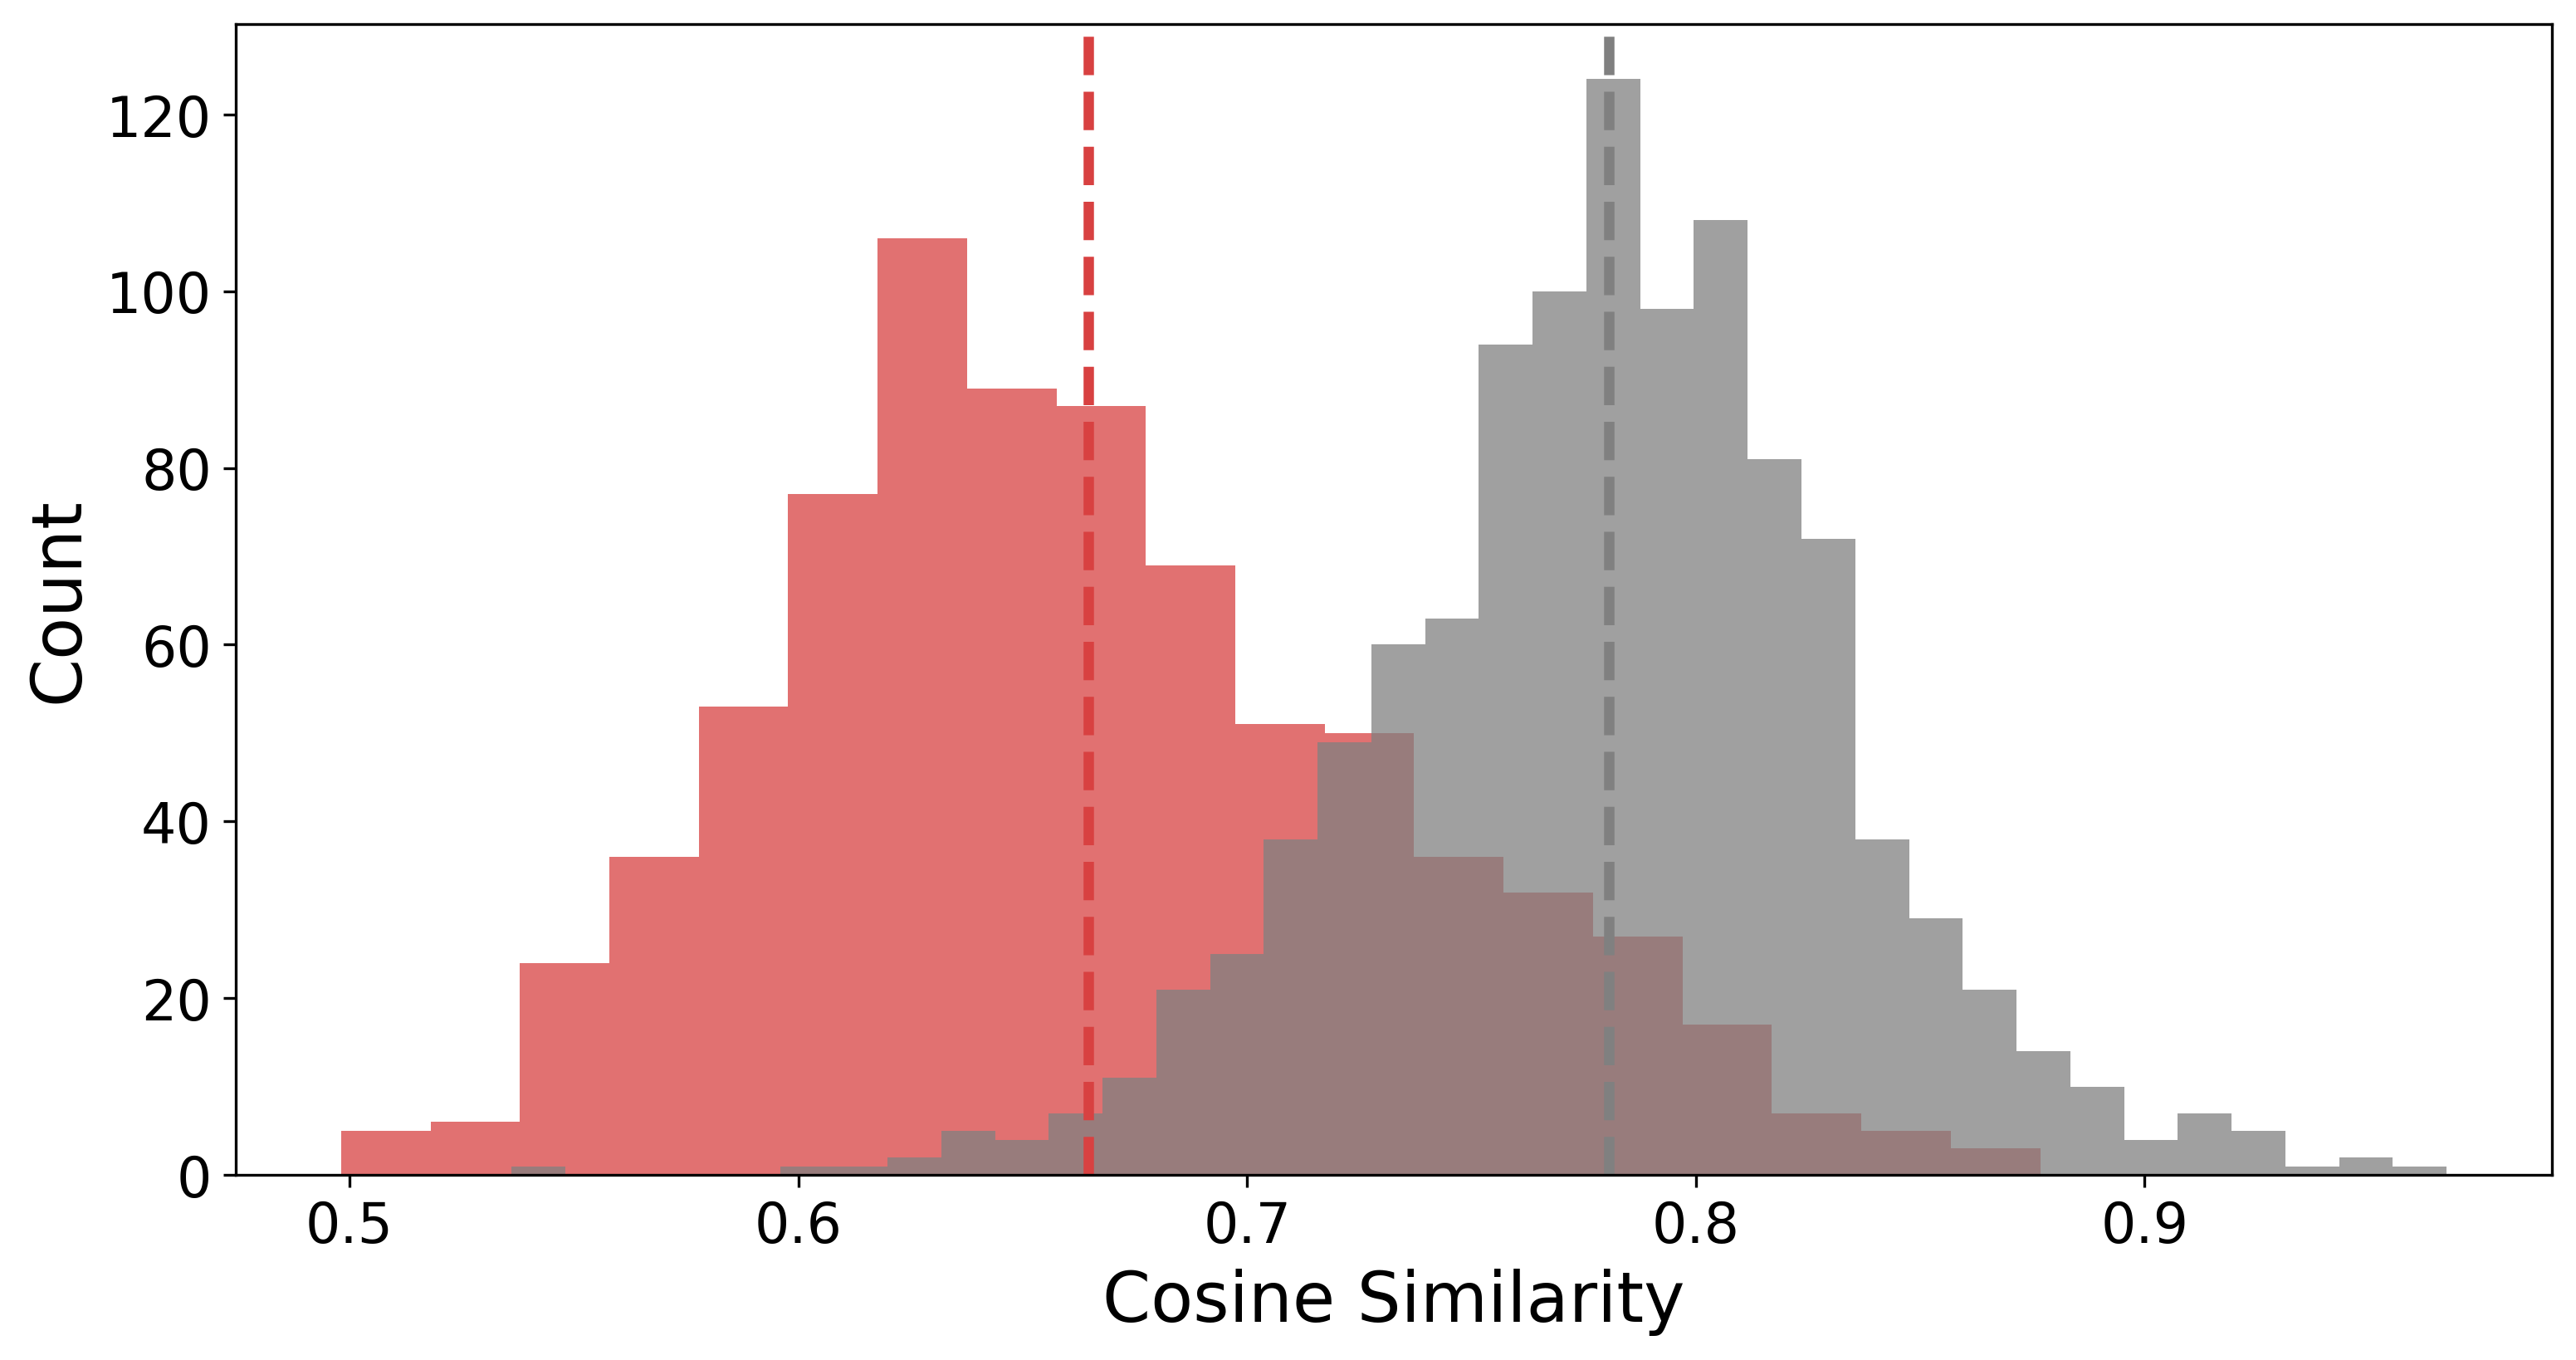

        close_literature  similarity
feature                             
家破人亡                社会危害    0.663858
下流                    策略    0.658000
不思进取                不当获利    0.647757
动力不足                危害财物    0.601118
冥顽不灵                  肮脏    0.643694
斤斤计较                危害他人    0.616512
未经允许                危害他人    0.634059
粗枝大叶                自利动机    0.536038
鬼鬼祟祟                  肮脏    0.634112
未经授权                危害他人    0.635476
搭便车                   肮脏    0.630239
双方同意                社会危害    0.655352
忘恩负义                正义违背    0.653596
歇斯底里                自我危害    0.647961
表面上                   策略    0.662919
偷偷摸摸                自我危害    0.619933
马基雅维利主义             违抗权威    0.636314
可辩护                 违抗权威    0.663208
Similarity ratio: 98.36%


In [6]:
plt.figure(figsize=(12, 6), dpi=300)
# literature
words_lit = filter_words(
    ['literature_review', 'literature_review&free_response', 'both'],
    ['evil', 'evil&good']
)
print(f'{len(words_lit)} words')
sim_matrix_lit = similarity_df.loc[words_lit, words_lit]
mask = np.tril(np.ones(sim_matrix_lit.shape, dtype=bool), k=-1)
lower_tri_values = sim_matrix_lit.values[mask]
sim_mean_lit = plot_histogram(lower_tri_values, "#d84141", "Literature")

# free response
words_free = filter_words(
    ['free_response', 'free_response&citespace', 'citespace'],
    ['evil', 'evil&good']
)
print(f'{len(words_free)} words')
sim_matrix_cross = similarity_df.loc[words_free, words_lit]
max_similarities = sim_matrix_cross.max(axis=1)
lit_free_close = pd.DataFrame({
    'close_literature': sim_matrix_cross.idxmax(axis=1),
    'similarity': max_similarities
})
sim_mean_free = plot_histogram(lit_free_close.similarity, 'gray', "Free Response")

plt.xlabel('Cosine Similarity', fontsize=20) 
plt.ylabel('Count', fontsize=20) 
plt.tick_params(axis='both', labelsize=16)
plt.show()

low_standard = lit_free_close[lit_free_close.similarity < sim_mean_lit]
print(low_standard)
similarity_ratio = 1 - (len(low_standard) / len(words_free))
print(f'Similarity ratio: {similarity_ratio:.2%}')

e:\anaconda3\envs\BERT\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\anaconda3\envs\BERT\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


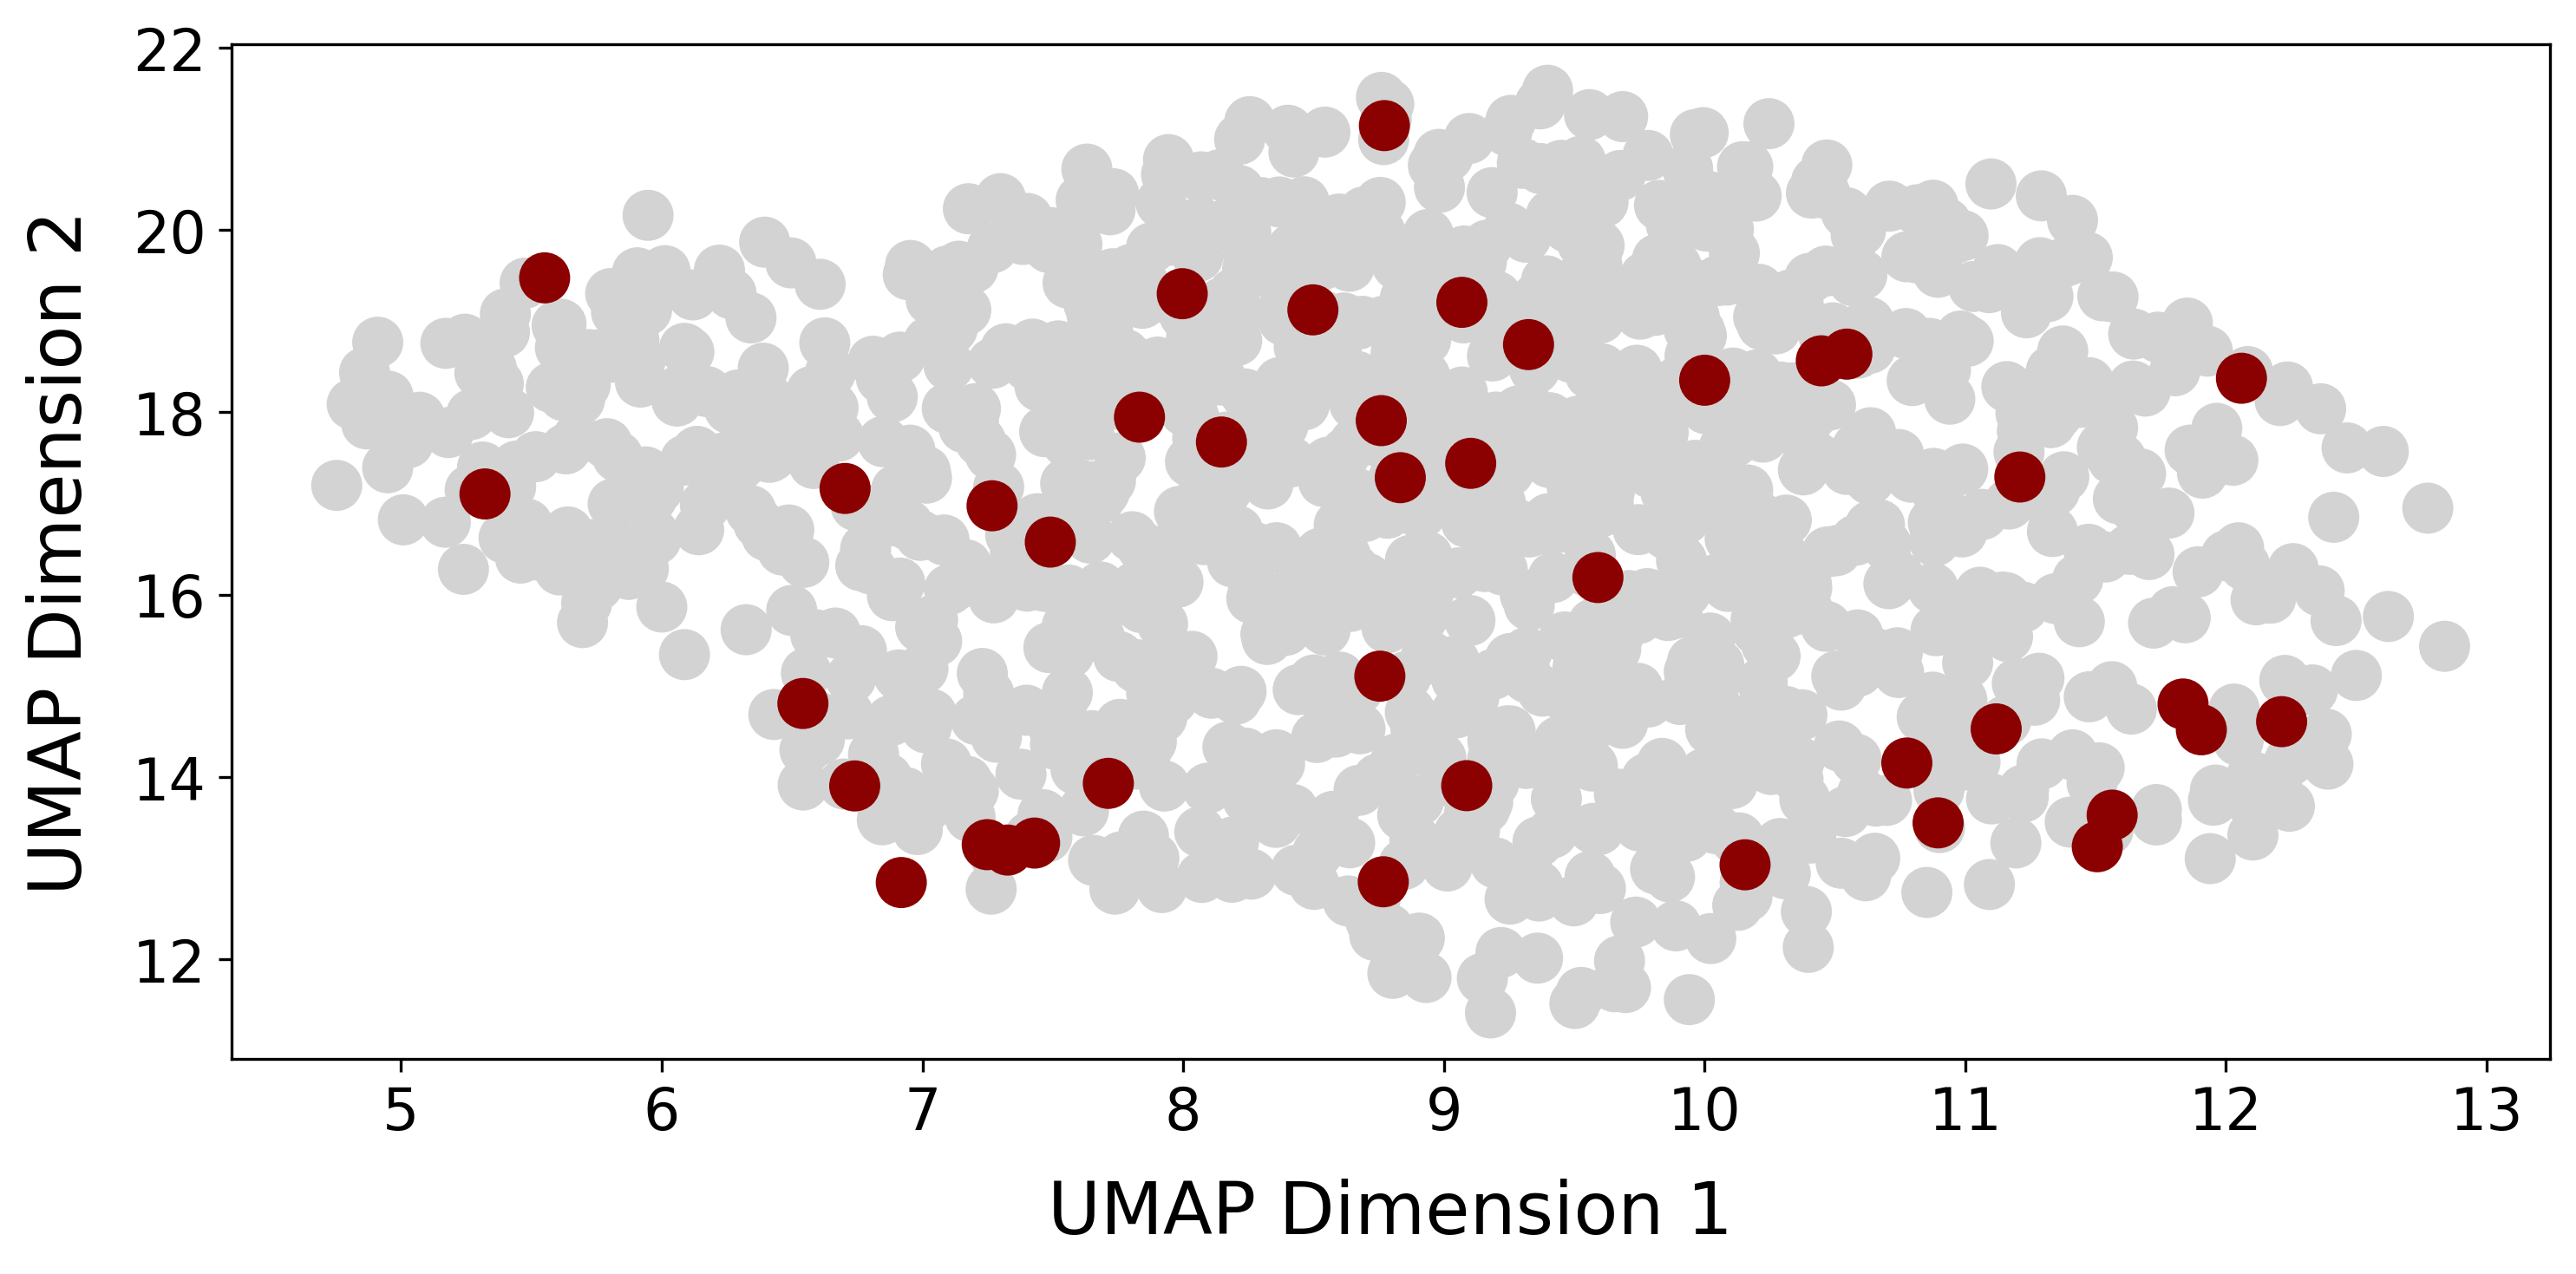

In [7]:
words_select_all = combine_feature.loc[combine_feature.type.isin(['evil', 'evil&good']),'feature'] 
data = vector_df.loc[words_select_all,]

bert_embed_umap = umap.UMAP(n_components=2, n_neighbors=500, min_dist=1, random_state=2025).fit_transform(data)
bert_embed_umap = pd.DataFrame(bert_embed_umap,columns = ['Dim1','Dim2'])
bert_embed_umap['word'] = data.index
bert_embed_umap['type'] = bert_embed_umap['word'].apply(lambda word: 'literature' if word in list(words_lit) else 'other')
###########################################

plt.figure(figsize=(10, 5), dpi=300)

# free_response&citespace
bert_plot = bert_embed_umap
sns.scatterplot(
    data=bert_plot[bert_plot['type'].isin(['other'])],
    x='Dim1',
    y='Dim2',
    color='lightgray', 
    marker='o',        
    s=200,             
    alpha=1,        
    edgecolor='none',  
    zorder=1,         
    label='Free Response',
    legend=False
)

# literature
sns.scatterplot(
    data=bert_plot[bert_plot['type'] == 'literature'],
    x='Dim1',
    y='Dim2',
    color='#8b0000',      
    marker='o',        
    s=200,
    alpha=1,
    edgecolor='none',
    zorder=2,       
    label='Literature',
    legend=False
)

plt.xlabel("UMAP Dimension 1", 
           fontsize=20, labelpad=10)
plt.ylabel("UMAP Dimension 2", 
           fontsize=20, labelpad=10)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.show()

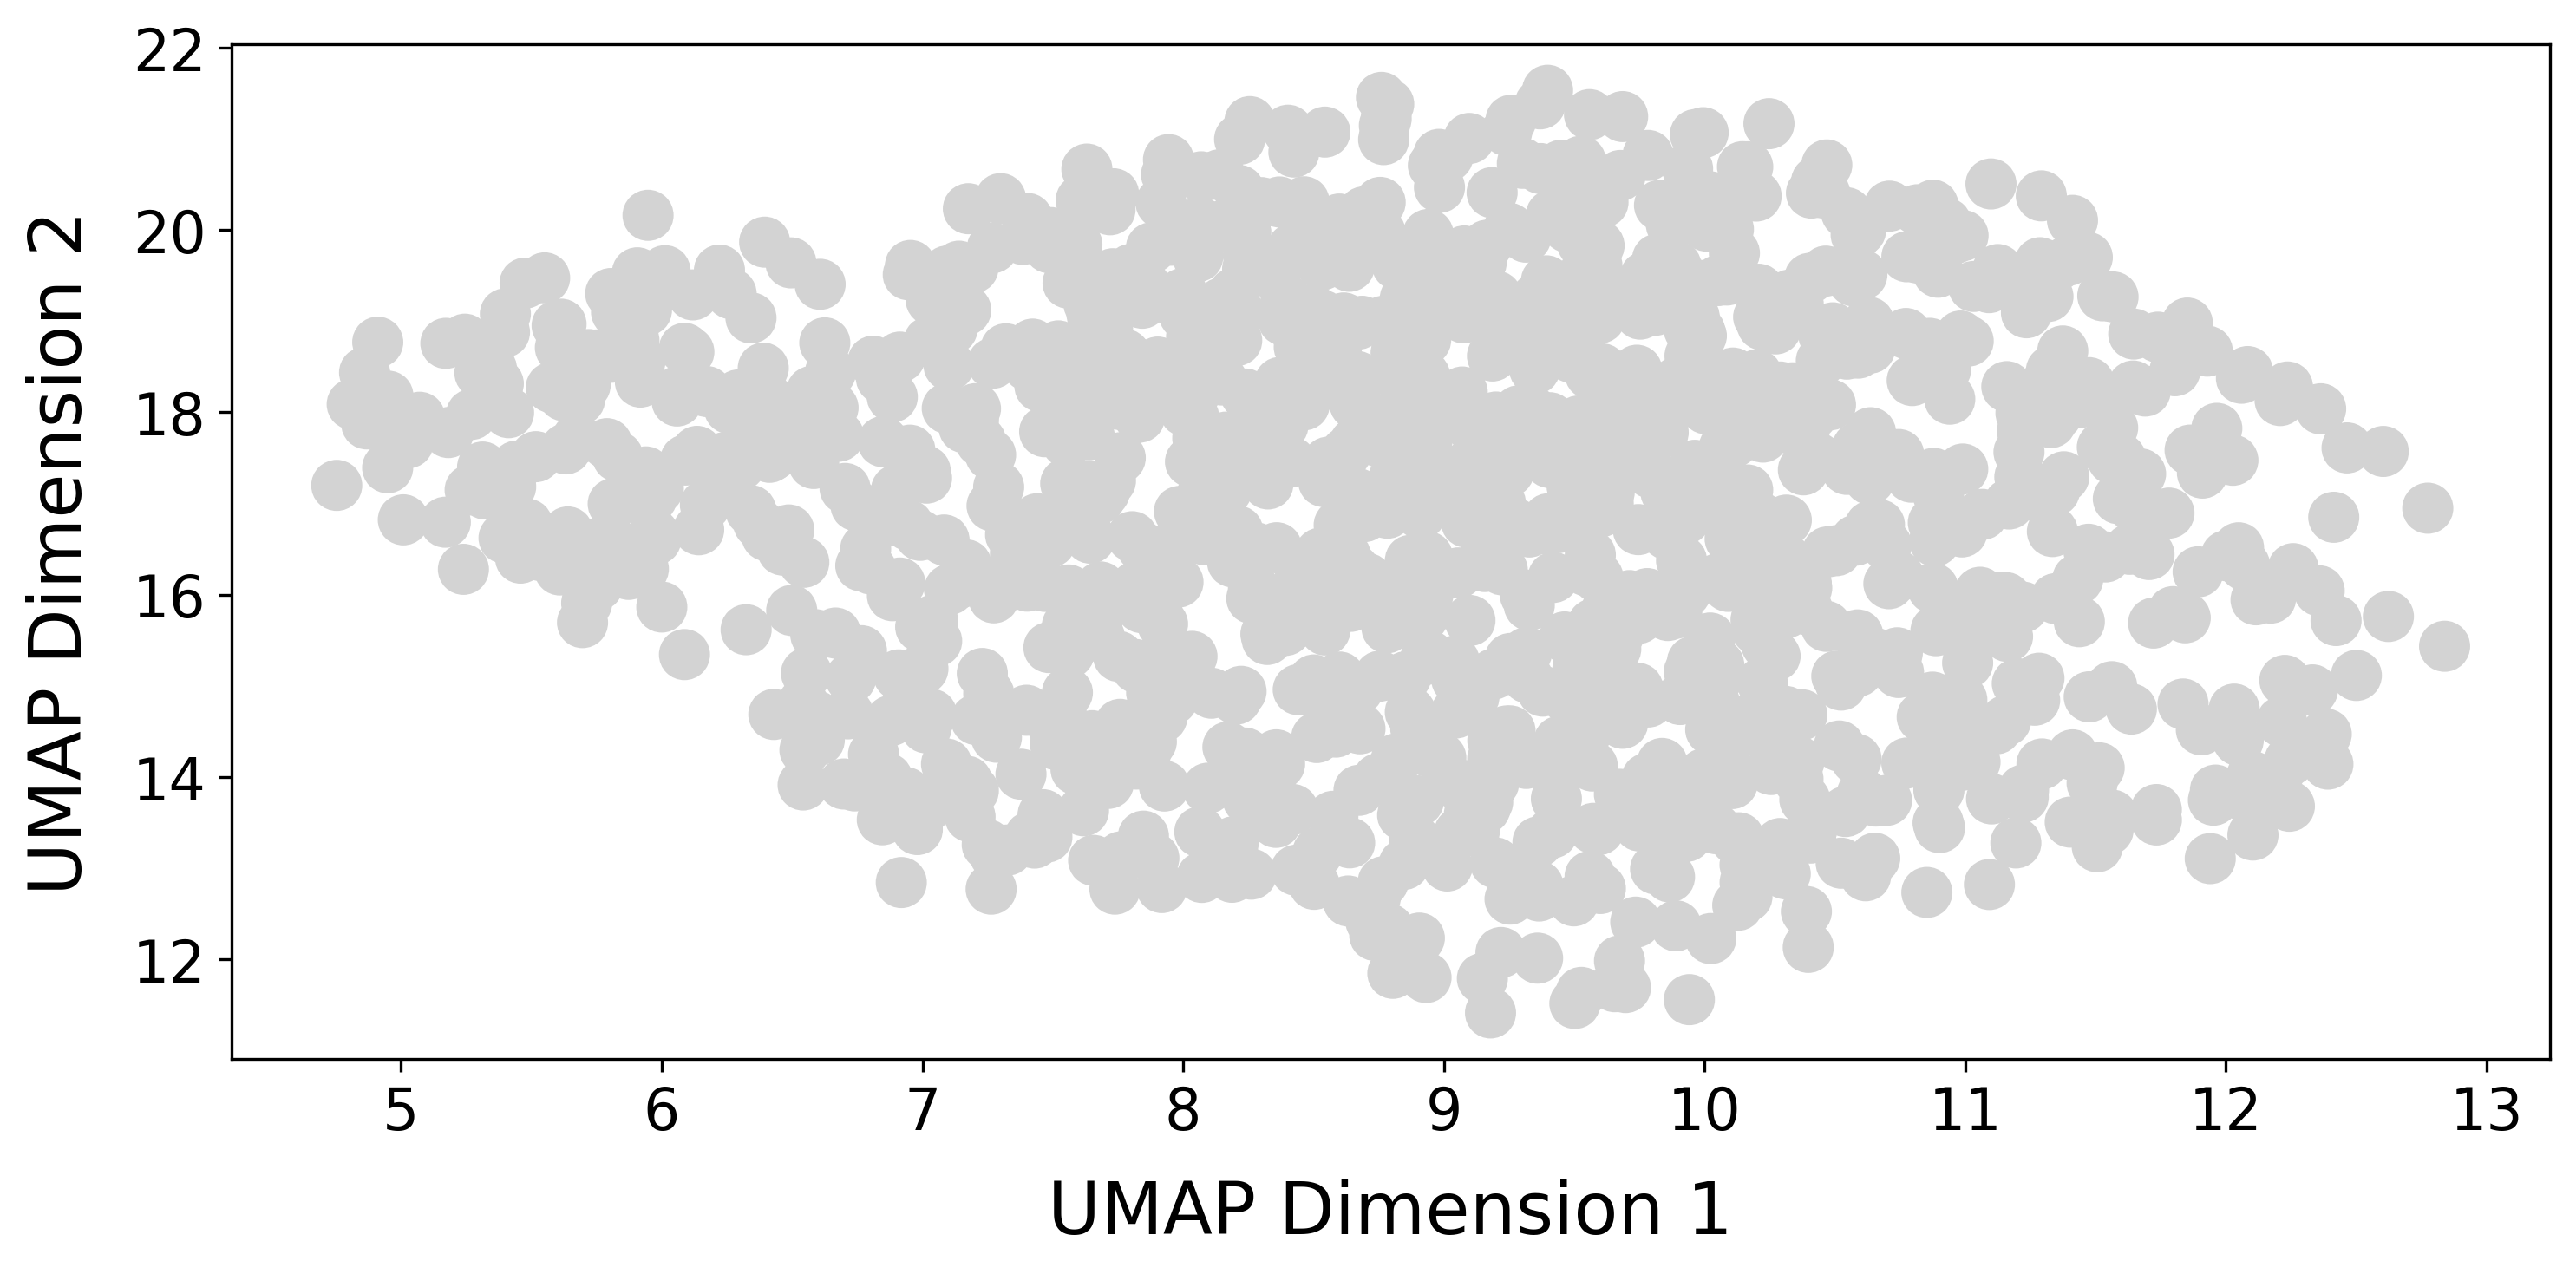

In [8]:
plt.figure(figsize=(10, 5), dpi=300)

# free_response&citespace
bert_plot = bert_embed_umap
sns.scatterplot(
    data=bert_plot[bert_plot['type'].isin(['other'])],
    x='Dim1',
    y='Dim2',
    color='lightgray', 
    marker='o',        
    s=200,             
    alpha=1,        
    edgecolor='none',  
    zorder=1,         
    label='Free Response',
    legend=False
)

# literature
sns.scatterplot(
    data=bert_plot[bert_plot['type'] == 'literature'],
    x='Dim1',
    y='Dim2',
    color='lightgray',      
    marker='o',        
    s=200,
    alpha=1,
    edgecolor='none',
    zorder=2,       
    label='Literature',
    legend=False
)

plt.xlabel("UMAP Dimension 1", 
           fontsize=20, labelpad=10)
plt.ylabel("UMAP Dimension 2", 
           fontsize=20, labelpad=10)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.show()

## Good

40 words
Mean: 0.6769
1099 words
Mean: 0.7831


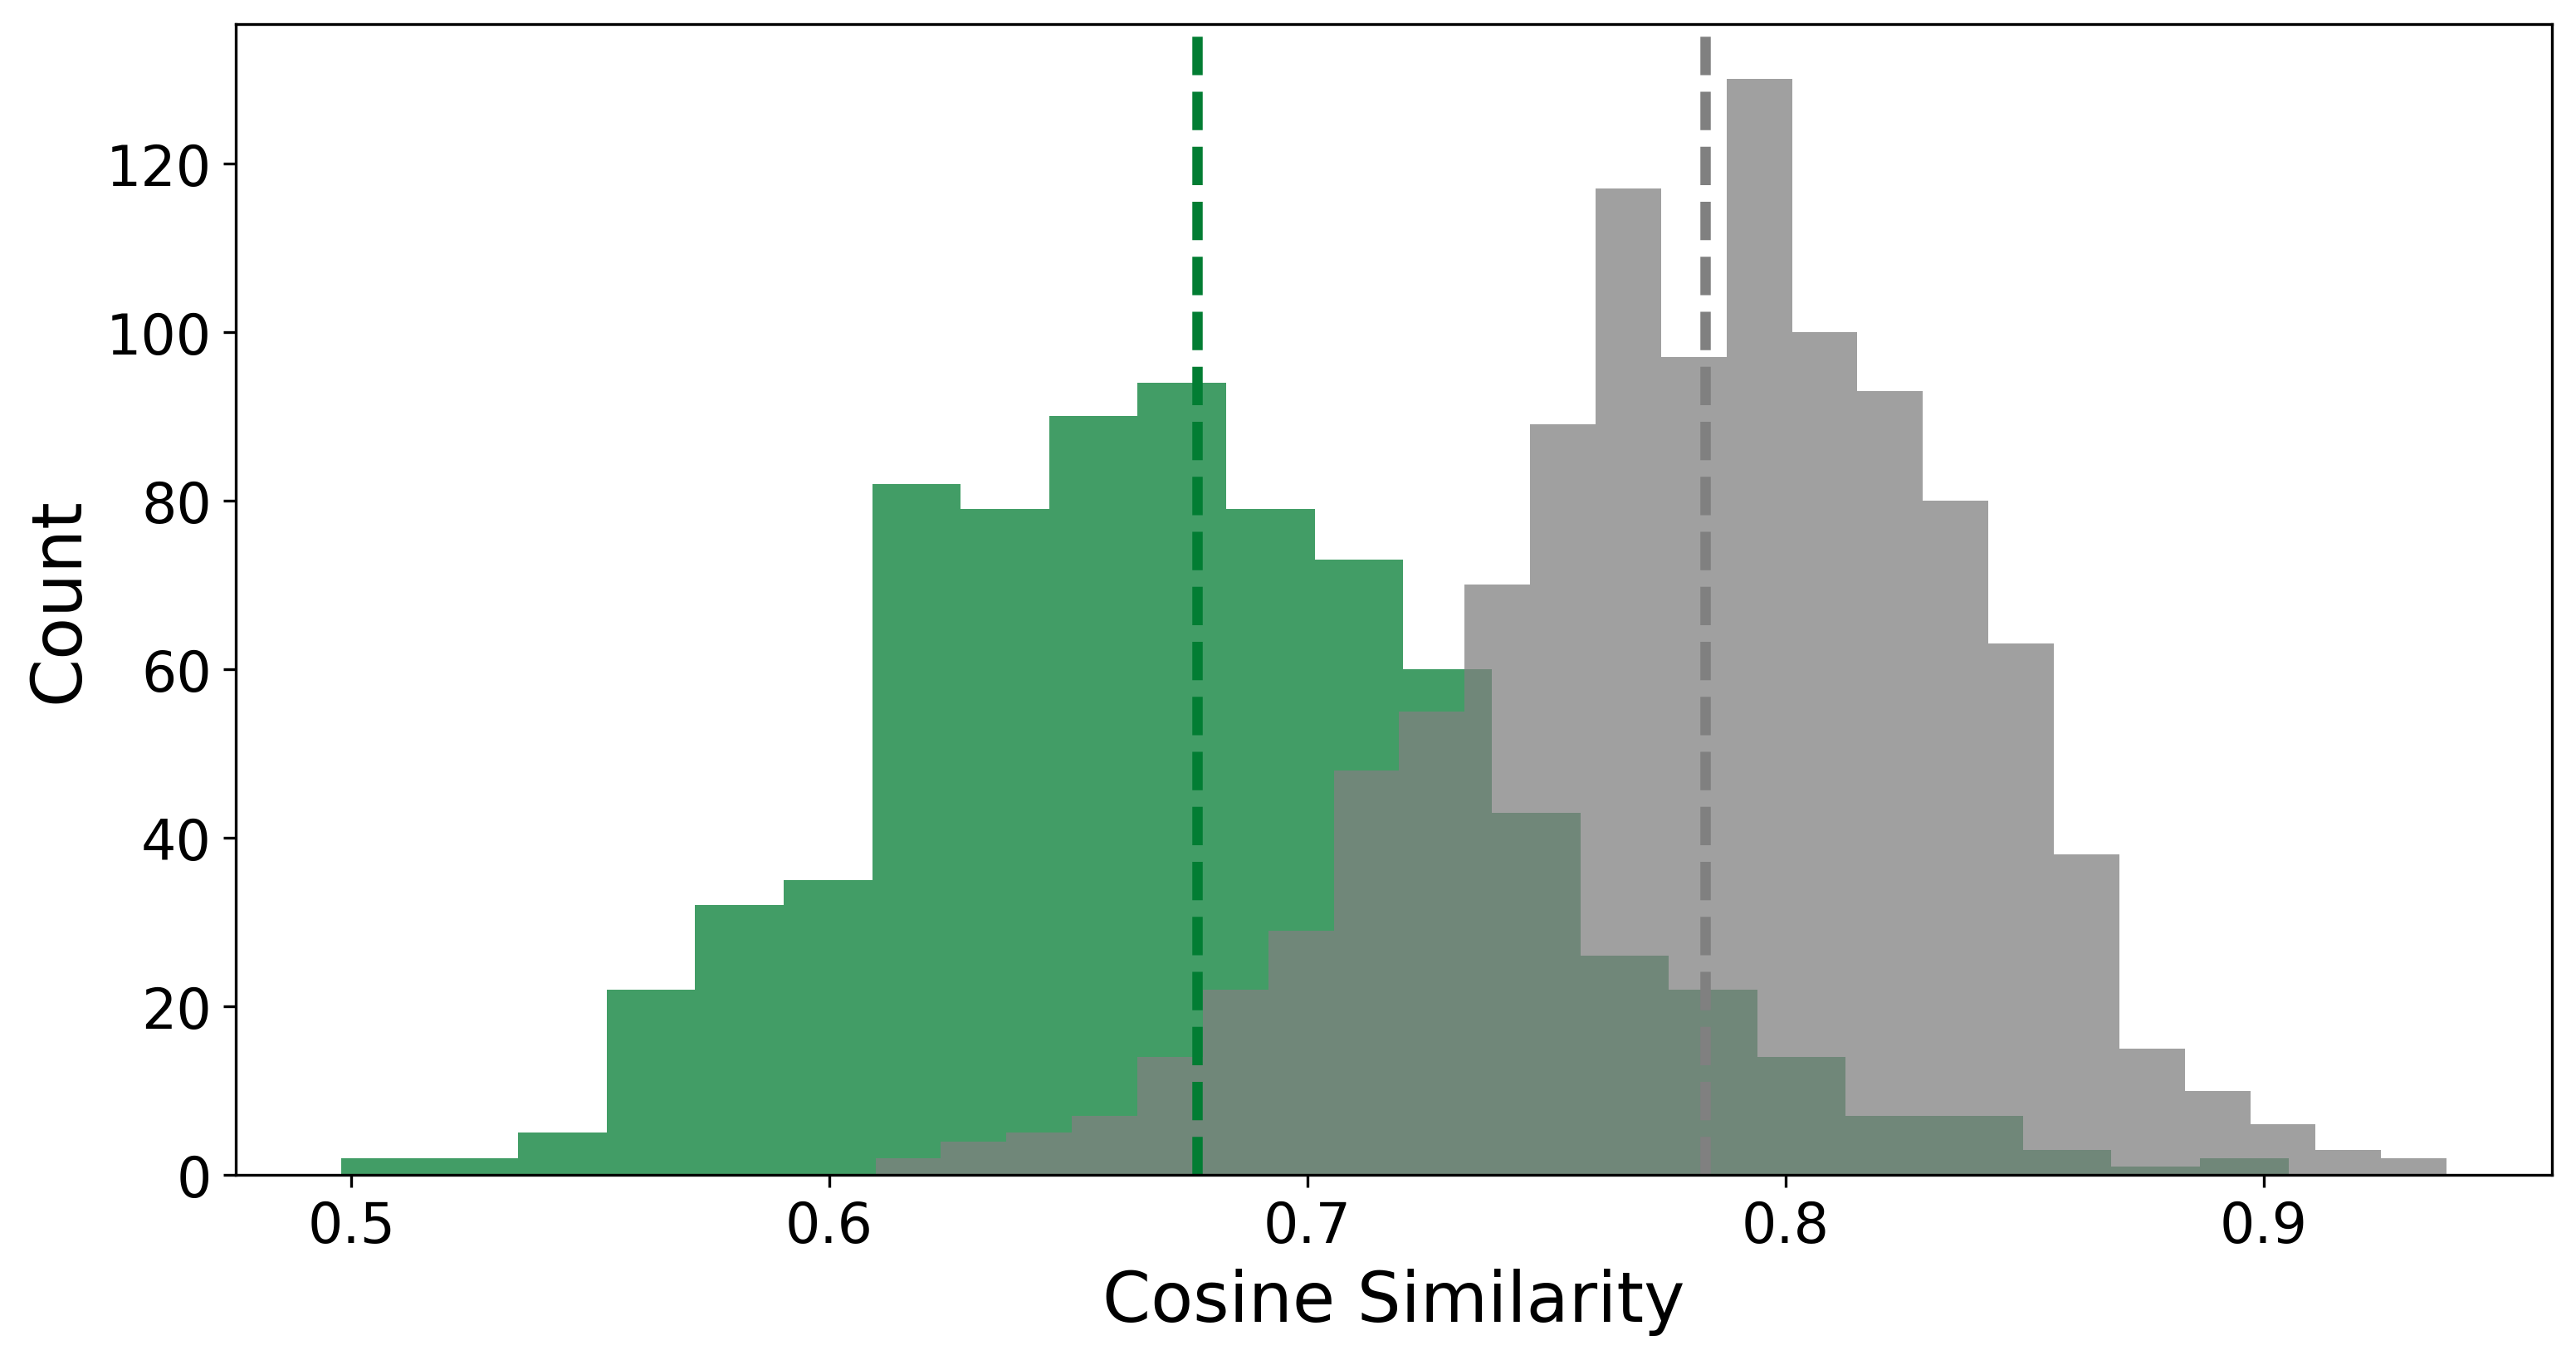

        close_literature  similarity
feature                             
任劳任怨                  责任    0.664965
规划                    责任    0.655780
树立榜样                社会贡献    0.674091
全神贯注                物质投入    0.640628
慰藉                  名誉获益    0.630108
公民意识                主体能力    0.669495
知书达理                关心他人    0.645758
唯物主义                物质利他    0.627777
宽宏大量                生命利他    0.668718
传统文化                  认同    0.631053
懂事                    快乐    0.668222
陶冶情操                关心他人    0.609636
可持续发展               关心他人    0.673575
安全保障                 自控力    0.622811
加强宣传                规范遵守    0.658552
脚踏实地                  诚实    0.669562
无家可归                关心他人    0.663487
警觉                    热情    0.670907
批判性思维               勇敢相关    0.657876
准备充分                物质投入    0.665179
细致入微                精神利他    0.649199
无拘无束                关心他人    0.642919
超凡脱俗                精神利他    0.675823
直截了当                勇敢相关    0.660523
表面上                   感激    0.642394
多

In [9]:
plt.figure(figsize=(12, 6), dpi=300)
# literature
words_lit = filter_words(
    ['literature_review', 'literature_review&free_response', 'both'],
    ['good', 'evil&good']
)
print(f'{len(words_lit)} words')
sim_matrix_lit = similarity_df.loc[words_lit, words_lit]
mask = np.tril(np.ones(sim_matrix_lit.shape, dtype=bool), k=-1)
lower_tri_values = sim_matrix_lit.values[mask]
sim_mean_lit = plot_histogram(lower_tri_values, "#027d33", "Literature")

# free response
words_free = filter_words(
    ['free_response', 'free_response&citespace', 'citespace'],
    ['good', 'evil&good']
)
print(f'{len(words_free)} words')
sim_matrix_cross = similarity_df.loc[words_free, words_lit]
max_similarities = sim_matrix_cross.max(axis=1)
lit_free_close = pd.DataFrame({
    'close_literature': sim_matrix_cross.idxmax(axis=1),
    'similarity': max_similarities
})
sim_mean_free = plot_histogram(lit_free_close.similarity, 'gray', "Free Response")

plt.xlabel('Cosine Similarity', fontsize=20) 
plt.ylabel('Count', fontsize=20) 
plt.tick_params(axis='both', labelsize=16)
plt.show()

low_standard = lit_free_close[lit_free_close.similarity < sim_mean_lit]
print(low_standard)
similarity_ratio = 1 - (len(low_standard) / len(words_free))
print(f'Similarity ratio: {similarity_ratio:.2%}')

e:\anaconda3\envs\BERT\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\anaconda3\envs\BERT\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


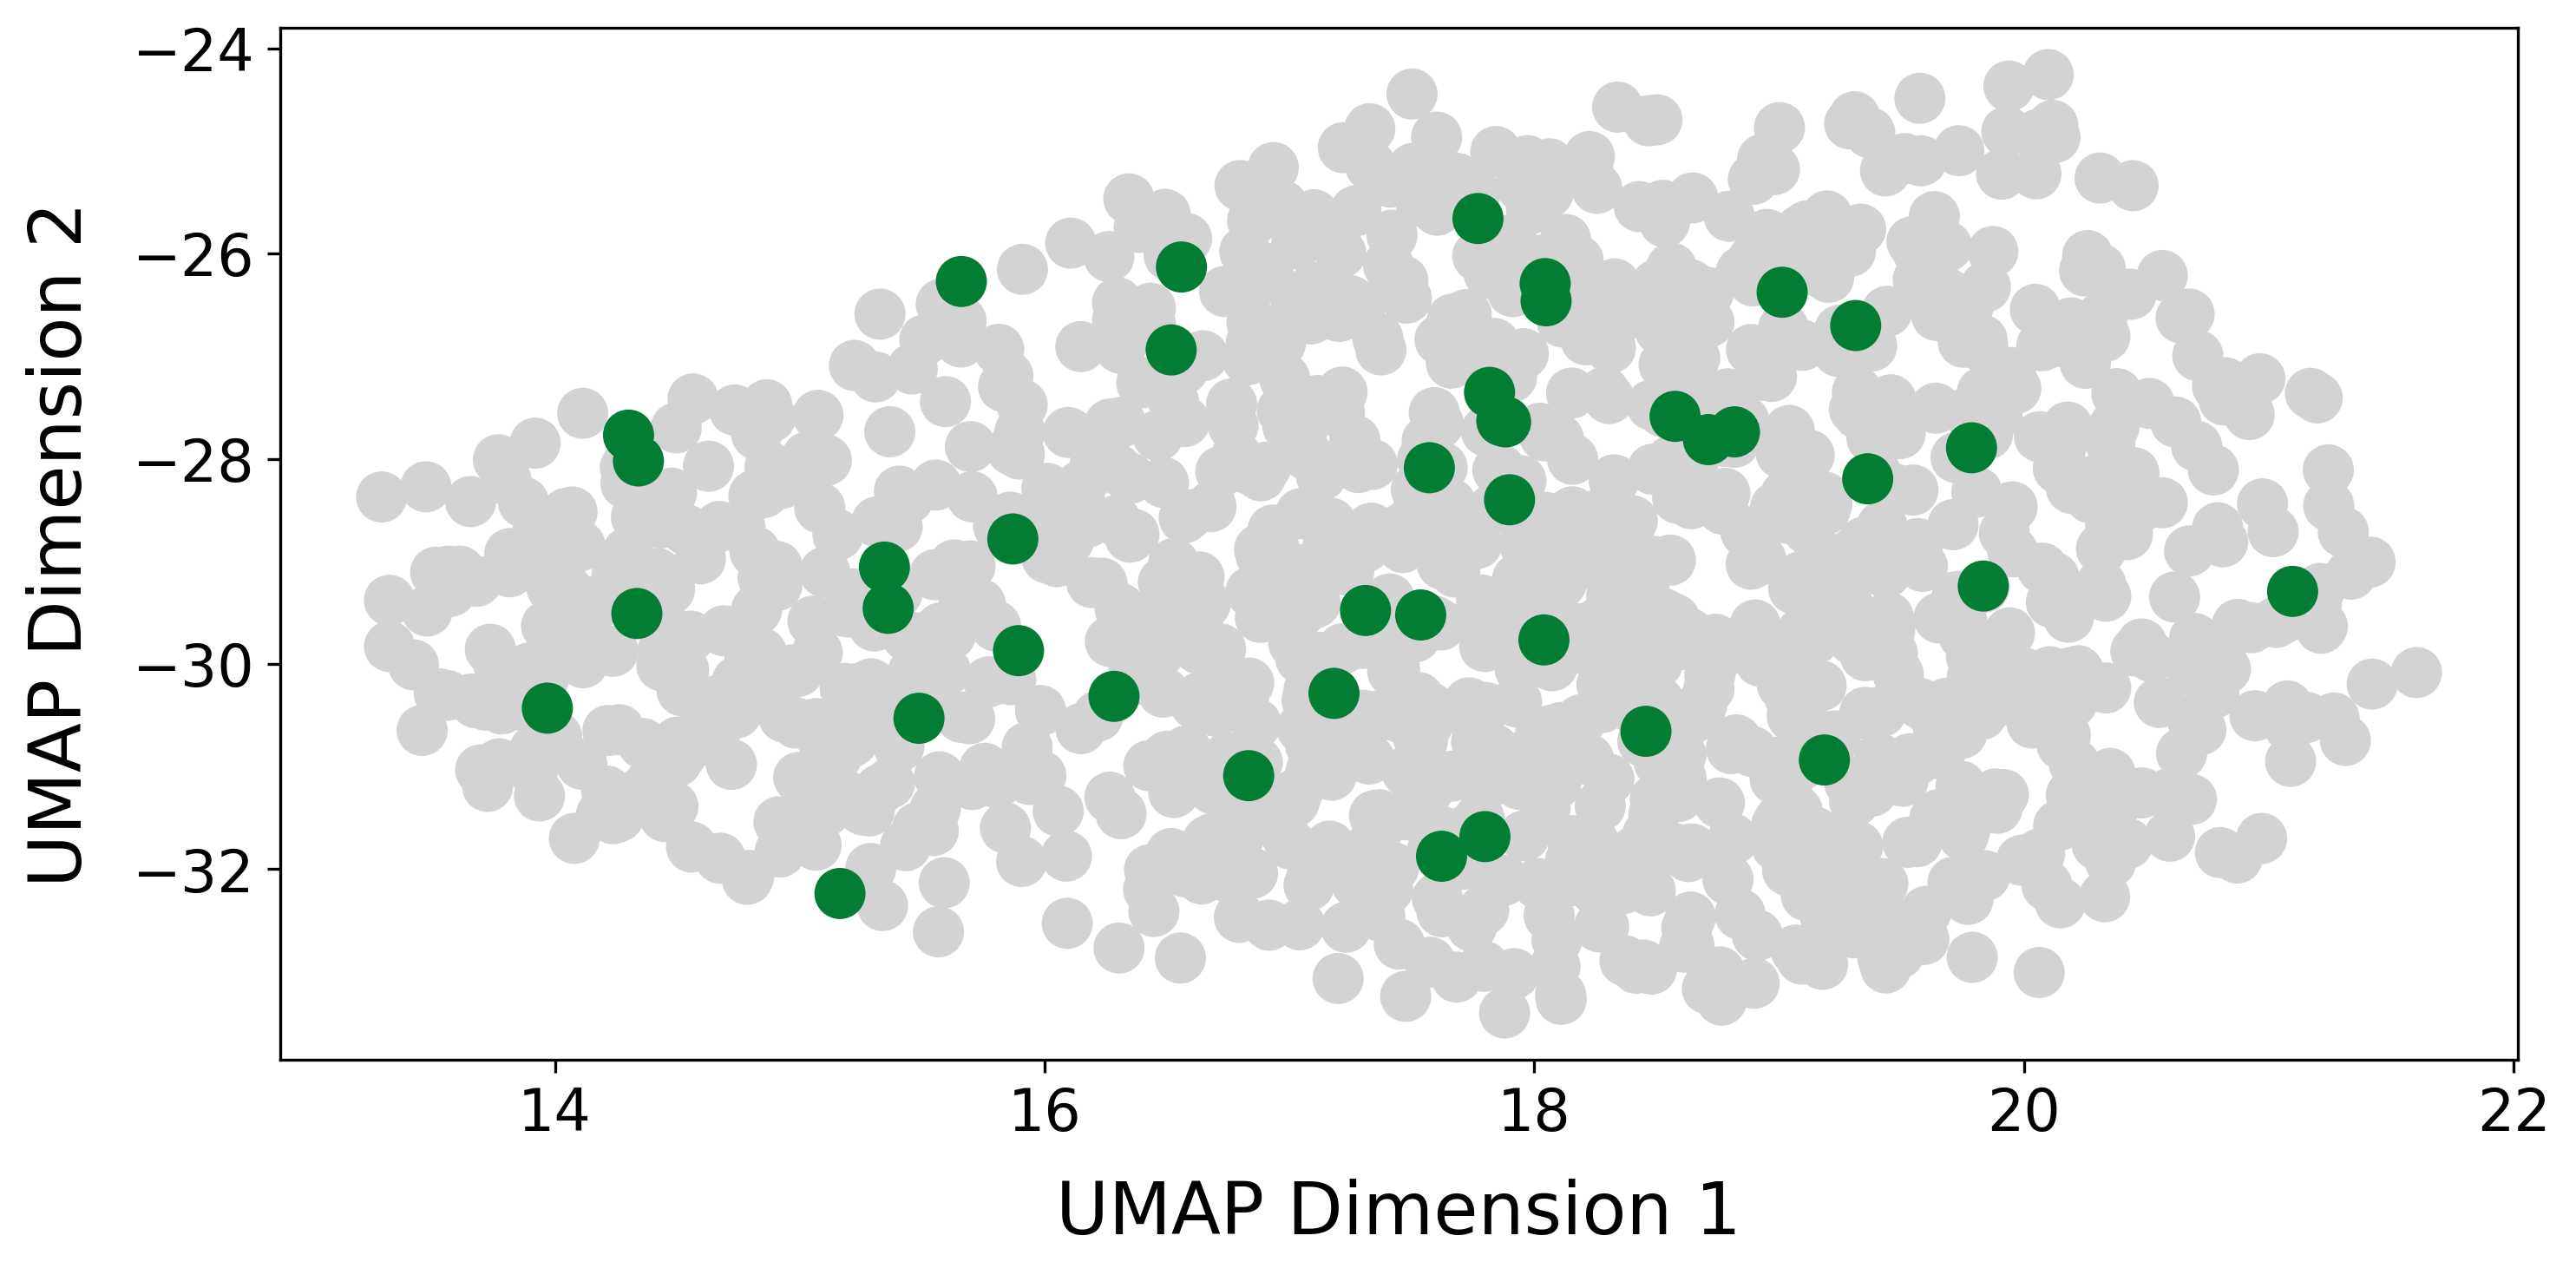

In [10]:
words_select_all = combine_feature.loc[combine_feature.type.isin(['good', 'evil&good']),'feature'] 
data = vector_df.loc[words_select_all,]

bert_embed_umap = umap.UMAP(n_components=2, n_neighbors=500, min_dist=1, random_state=33).fit_transform(data)
bert_embed_umap = pd.DataFrame(bert_embed_umap,columns = ['Dim1','Dim2'])
bert_embed_umap['word'] = data.index
bert_embed_umap['type'] = bert_embed_umap['word'].apply(lambda word: 'literature' if word in list(words_lit) else 'other')
###########################################

plt.figure(figsize=(10, 5), dpi=300)

# free_response&citespace
bert_plot = bert_embed_umap
sns.scatterplot(
    data=bert_plot[bert_plot['type'].isin(['other'])],
    x='Dim1',
    y='Dim2',
    color='lightgray', 
    marker='o',        
    s=200,             
    alpha=1,        
    edgecolor='none',  
    zorder=1,         
    label='Free Response',
    legend=False
)

# literature
sns.scatterplot(
    data=bert_plot[bert_plot['type'] == 'literature'],
    x='Dim1',
    y='Dim2',
    color='#027d33',      
    marker='o',        
    s=200,
    alpha=1,
    edgecolor='none',
    zorder=2,       
    label='Literature',
    legend=False
)

plt.xlabel("UMAP Dimension 1", 
           fontsize=20, labelpad=10)
plt.ylabel("UMAP Dimension 2", 
           fontsize=20, labelpad=10)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.show()

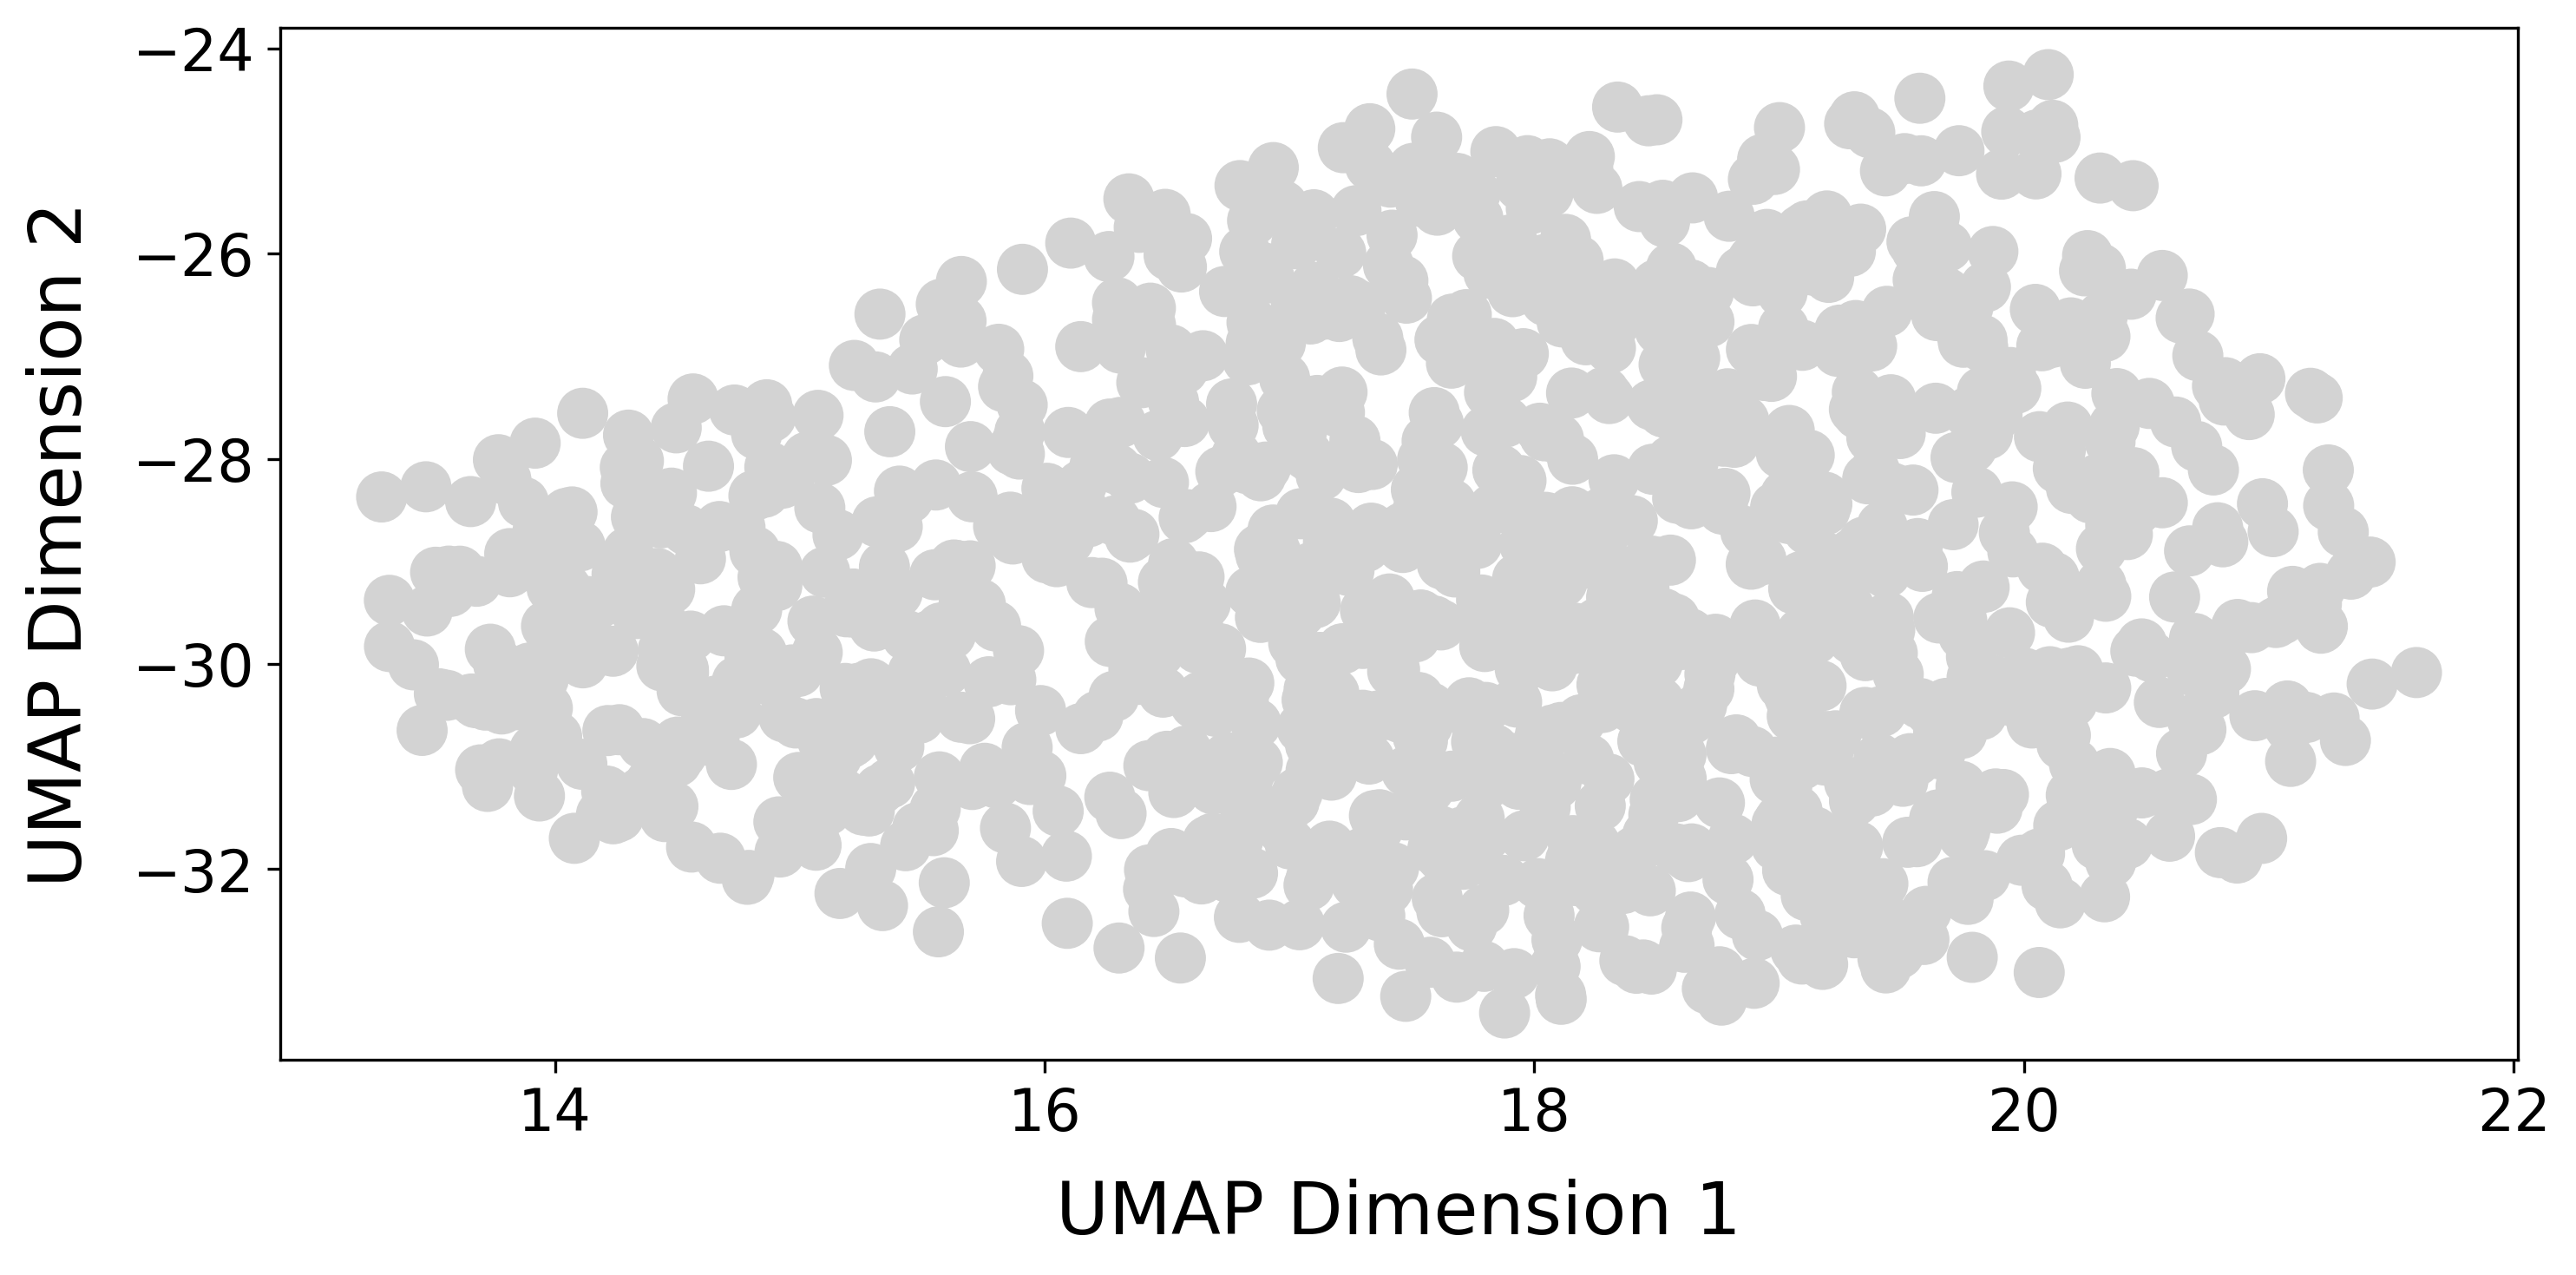

In [11]:
plt.figure(figsize=(10, 5), dpi=300)

# free_response&citespace
bert_plot = bert_embed_umap
sns.scatterplot(
    data=bert_plot[bert_plot['type'].isin(['other'])],
    x='Dim1',
    y='Dim2',
    color='lightgray', 
    marker='o',        
    s=200,             
    alpha=1,        
    edgecolor='none',  
    zorder=1,         
    label='Free Response',
    legend=False
)

# literature
sns.scatterplot(
    data=bert_plot[bert_plot['type'] == 'literature'],
    x='Dim1',
    y='Dim2',
    color='lightgray',      
    marker='o',        
    s=200,
    alpha=1,
    edgecolor='none',
    zorder=2,       
    label='Literature',
    legend=False
)

plt.xlabel("UMAP Dimension 1", 
           fontsize=20, labelpad=10)
plt.ylabel("UMAP Dimension 2", 
           fontsize=20, labelpad=10)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.show()